In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import glob
import os
from mpl_toolkits.basemap import Basemap
# from scipy.stats import pearsonr
import scipy.interpolate
### modified from ~/Documents/nhchi_work_2022/check_topography/make_topo_on_SMAPgrid.ipynb
### generate a topography file of full longitude circle

In [8]:
### Get SMAP grid & and make it to the full longitude circle (0-360 deg)
pathSSS = os.path.expanduser('~/Documents/Data/podaac-tools.jpl.nasa.gov/smap/L3/JPL/')
fileloc = glob.glob(pathSSS+'*.nc')
filename = os.path.basename(fileloc[0])
ds = nc.Dataset(pathSSS+filename)
lonS = ds.variables['longitude'][:]
# print(lonS[0:5])
lonS = np.arange(0.125,360.125,lonS[1]-lonS[0])
latS = ds.variables['latitude'][:]
print('SMAP grids: ',lonS.size, latS.size)
# del ds

SMAP grids:  1440 160


In [10]:
### Settings
# range of the map
pathOutput = os.path.expanduser('~/Documents/Data/Topography/')
########## import bathymetry data
pathB = os.path.expanduser('~/Documents/Data/Topography/')
filenameB = 'usgsCeSrtm30v6_90N_50N.nc'
ds = nc.Dataset(pathB+filenameB)
#print(ds)
latitude = ds.variables['latitude'][:]
longitude = ds.variables['longitude'][:]
longitude = (360+(longitude%360))%360
sort_index = np.argsort(longitude)
longitude = np.sort(longitude)
topo = ds.variables['topo'][:]
# sort
topo = topo[:,sort_index]
# ########## look at smaller domain
# ilat = list( np.ma.where( (latitude>= min(latS)-1) & (latitude<= max(latS)+1) )[0] )
# ilon = list( np.ma.where( (longitude>= min(lonS)-10) & (longitude<= max(lonS)+10) )[0] )
# lat_sub = latitude[ilat]
# lon_sub = longitude[ilon]
# topo_sub = topo[np.ix_(ilat,ilon)]

In [11]:
### interpolate topography data to SMAP grid
print('topo grids: ',longitude.shape, latitude.shape, topo.shape)
f = scipy.interpolate.interp2d(longitude, latitude, topo, kind='linear',fill_value=np.nan)

topo grids:  (43200,) (4801,) (4801, 43200)


(1440,) (160,) (160, 1440)
[0.125, 359.875]
[50.125, 89.875]
[-7548.0, 4845.0]


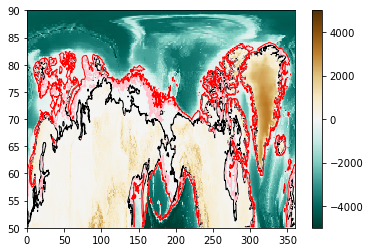

In [12]:
lon_out = lonS
lat_out = latS
topo_out = f(lon_out,lat_out)
print(lon_out.shape, lat_out.shape, topo_out.shape)
print([min(lon_out),max(lon_out)])
print([min(lat_out),max(lat_out)])
print([np.min(topo_out),np.max(topo_out)])
### plot
plt.clf()
plt.pcolor(lon_out,lat_out,topo_out,vmin=-5000,vmax=5000,cmap='BrBG_r',shading='nearest')
plt.colorbar()
plt.contour(lon_out,lat_out,topo_out,linestyles='solid',levels=[0],linewidths=1,colors='black')
plt.contour(lon_out,lat_out,topo_out,linestyles='solid',levels=[-100],linewidths=1,colors='pink')
plt.contour(lon_out,lat_out,topo_out,linestyles='solid',levels=[-200],linewidths=1,colors='red')


In [13]:
### save new gridded topography data to file
# output netcdf file
try: ncfile.close() # just to be safe, make sure dataset is not already open.
except: pass
ncfile = nc.Dataset(pathOutput+'usgsCeSrtm30v6_Arctic'+'.nc',mode='w',format='NETCDF4') 
print(ncfile)
# Creating dimensions
longitude_dim = ncfile.createDimension('longitude',len(lon_out)) # longitude axis
latitude_dim = ncfile.createDimension('latitude',len(lat_out)) # latitude axis
for dim in ncfile.dimensions.items():
    print(dim)
# Creating attributes
ncfile.title = 'usgsCeSrtm30v6 Topography data on SMAP 0.25x0.25 grid'
ncfile.description = \
' >>> From '+pathB+' slice the area of interest and then interpolate the topography data :'+\
    '. Slice area: longitude: '+str(min(lonS))+' ~ '+str(max(lonS))+\
        '; latitude: '+str(min(latS))+' ~ '+str(max(latS))\
            +'. Area of interest: Arctic.'
ncfile.subtitle = 'Created by Nan-Hsun Chi '+str(datetime.datetime.now())
print(ncfile.title)
print(ncfile.description)
print(ncfile.subtitle)
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 1440)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 160)
usgsCeSrtm30v6 Topography data on SMAP 0.25x0.25 grid
 >>> From /Users/chi/Documents/Data/Topography/ slice the area of interest and then interpolate the topography data :. Slice area: longitude: 0.125 ~ 359.875; latitude: 50.125 ~ 89.875. Area of interest: Arctic.
Created by Nan-Hsun Chi 2023-02-09 10:10:47.274690
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: usgsCeSrtm30v6 Topography data on SMAP 0.25x0.25 grid
    description:  >>> From /Users/chi/Documents/Data/Topography/ slice the area of interest and then interpolate the topography data :. Slice area: longitude: 0.125 ~ 359.875; latitude: 50.125 ~ 89.875. Area of int

In [14]:
# Creating Variables:
# A variable has a name, a type, a shape, and some data values.
# The shape of a variable is specified by a tuple of dimension names.
# A variable should also have some named attributes, such as 'units', that describe the data.
# Define two variables with the same names as dimensions, a conventional way to define "coordinate variables".
###
latitude = ncfile.createVariable('latitude', np.float32, ('latitude',),fill_value=np.nan);
latitude._CoordinateAxisType = "Lat" ;
latitude.actual_range = min(latS),max(latS) ;
latitude.axis = "Y" ;
latitude.ioos_category = "Location" ;
latitude.long_name = "Latitude" ;
latitude.standard_name = "latitude" ;
latitude.units = "degrees_north" ;
###
longitude = ncfile.createVariable('longitude', np.float32, ('longitude',),fill_value=np.nan);
longitude._CoordinateAxisType = "Lon" ;
longitude.actual_range = min(lonS),max(lonS) ;
longitude.axis = "X" ;
longitude.ioos_category = "Location" ;
longitude.long_name = "Longitude" ;
longitude.standard_name = "longitude" ;
longitude.units = "degrees_east" ;
########## Define a variable to hold the data ##########
topo = ncfile.createVariable('topo',np.float64,('latitude','longitude'),fill_value=np.nan);
topo.colorBarMaximum = 8000. ;
topo.colorBarMinimum = -8000. ;
topo.colorBarPalette = "Topography" ;
topo.grid_mapping = "GDAL_Geographics" ;
topo.ioos_category = "Location" ;
topo.long_name = "Topography" ;
topo.standard_name = "altitude" ;
topo.units = "meters" ;

In [15]:
# Writing data
# To write data a netCDF variable object, just treat it like a numpy array and assign values to a slice.
longitude[:] = lon_out
latitude[:] = lat_out
topo[:,:] = topo_out
# read data back from variable (by slicing it), print min and max
print("-- Wrote data, longitude.shape is now ", longitude.shape)
print("-- Min/Max values:", np.amin(longitude), np.amax(longitude))
print("-- Wrote data, topo.shape is now ", topo.shape)
print("-- Min/Max values:", np.amin(topo), np.amax(topo))

-- Wrote data, longitude.shape is now  (1440,)
-- Min/Max values: 0.125 359.875
-- Wrote data, topo.shape is now  (160, 1440)
-- Min/Max values: -7548.0 4845.0


In [16]:
# Closing a netCDF file
# It's important to close a netCDF file you opened for writing:
# flushes buffers to make sure all data gets written
# releases memory resources used by open netCDF files
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); 
print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: usgsCeSrtm30v6 Topography data on SMAP 0.25x0.25 grid
    description:  >>> From /Users/chi/Documents/Data/Topography/ slice the area of interest and then interpolate the topography data :. Slice area: longitude: 0.125 ~ 359.875; latitude: 50.125 ~ 89.875. Area of interest: Arctic.
    subtitle: Created by Nan-Hsun Chi 2023-02-09 10:10:47.274690
    dimensions(sizes): longitude(1440), latitude(160)
    variables(dimensions): float32 latitude(latitude), float32 longitude(longitude), float64 topo(latitude, longitude)
    groups: 
Dataset is closed!
